# QTN + Trotterization Solution on a Real QPU:

Using IQM Garnet QPU

In previous notebooks we have successfully ran circuits without noise and with noise using a fake backend. Now we will run with noise but on a real QPU from  IQM.

In [ ]:
#!pip install iqm-benchmarks

In [ ]:
#!pip install iqm-client[qiskit]

In [ ]:
#!pip install qiskit==1.2.4
#!pip install qiskit-algorithms==0.3.1

### Outline:
<ol>
<li>Required imports.</li>
<li>Backend.</li>
<li>Circuit Preparation.</li>
<li>Running the circuits and retrieving the results.</li>
<li>Dynamic decoupling vs readout error mitigation.</li>
<li>ZNE only.</li>
<li>Comparison</li>
<li>Versions.</li>
</ol>

### Required imports:

In [ ]:
import qiskit.qasm2 as qasm2
from qiskit import *
from qiskit.quantum_info import Statevector

from iqm.iqm_client.models import CircuitCompilationOptions
from iqm.iqm_client.models import DDMode, DDStrategy

from iqm import qiskit_iqm
from iqm.qiskit_iqm import IQMProvider
from iqm.benchmarks.readout_mitigation import apply_readout_error_mitigation

import numpy as np

import warnings
warnings.filterwarnings('ignore')

n = 4
grid_points = 2**n
shots = 1000

### Backend:

IQM Garnet is a 20-qubit quantum processing unit based on superconducting transmon qubits. The qubits are arranged in a square lattice and connected by tunable couplers. The system is calibrated to support arbitrary X and Y rotations as the native single-qubit gate and CZ as the native two-qubit gate.

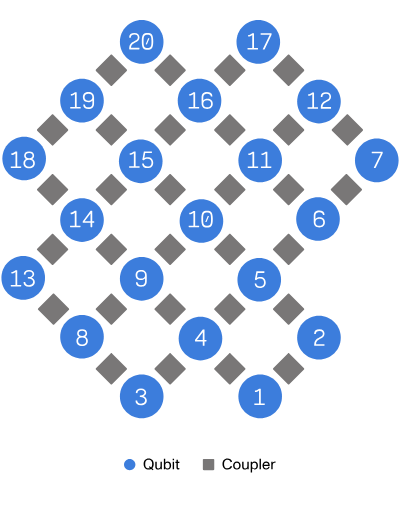

In [ ]:
server_url = "https://cocos.resonance.meetiqm.com/garnet"
provider = IQMProvider(server_url, token="")

In [ ]:
backend = provider.get_backend()

### Circuit preparation:

As we have done in a previous notebook, to not write the code for QTN and trotterization another time, as the code is big, we import the pre-built qasm files. One file contains the MPS circuit representation and the other file contains the trotter operator circuit. Due to few credits, we will run the solution for just 1 step.

In [ ]:
qasm_path = "/content/MPS_Circuit_4.qasm"   # path to your QASM2 file
with open(qasm_path, "r") as f:
    qasm_str = f.read()

In [ ]:
qc1 = QuantumCircuit.from_qasm_str(qasm_str)

In [ ]:
qasm_path = "/content/LieTrotter_operator_4.qasm"   # path to your QASM2 file
with open(qasm_path, "r") as f:
    qasm_str = f.read()

In [ ]:
qc2 = QuantumCircuit.from_qasm_str(qasm_str)

In [ ]:
qc = qc1.compose(qc2)

We will save the ideal state, without noise. This state will be later compared with the state with noise and with and without error correction.

In [ ]:
ideal = Statevector(qc).data
np.real(ideal)

array([ 9.98013860e-01,  4.48166658e-02,  1.31500775e-03,  8.65165178e-05,
        2.53856215e-06,  1.67016170e-07,  4.90057789e-09,  3.22718337e-10,
        3.24817402e-10,  1.47884326e-11,  4.34041583e-13,  2.85908382e-14,
        8.63550513e-16,  1.71728717e-17,  1.03880625e-17, -3.03592097e-17])

In [ ]:
qc.measure_all()

In [ ]:
qcirc = transpile(qc, backend, optimization_level=3)

In [ ]:
print("Depth of the transpiled circuit = ", qcirc.depth())

Depth of the transpiled circuit =  95


In [ ]:
print("Gates decomposition and counts in the transpiled circuit: ", qcirc.count_ops())

Gates decomposition and counts in the transpiled circuit:  OrderedDict([('r', 85), ('cz', 50), ('measure', 4), ('barrier', 1)])


### Running the circuit and retrieving the results:

In this section we will calculate the noisy results without error correction.

All the circuits in this notebook will be run for 1000 shots.

In [ ]:
job_noisy = backend.run(qcirc, shots=1000)

In [ ]:
job_noisy.job_id()

'01988f43-6ec6-73b0-8070-64c0ad90a9e8'

In [ ]:
retrieved_job_noisy = backend.retrieve_job(job_noisy.job_id())
print(retrieved_job_noisy.status())

JobStatus.RUNNING


In [ ]:
result_noisy = retrieved_job_noisy.result()
#print(result.get_counts())

We are interested in the final statevector but the quantum circuit returns the measurement counts and the statevector cannot be accessed directly in the real QPU. So we get the counts then we build the statevector from the counts.  

In [ ]:
counts_noisy = result_noisy.get_counts()

psi_noisy = np.array([counts_noisy.get(bin(i).replace('0b', '').zfill(n), 0) for i in range(grid_points)])
psi_noisy = np.sqrt(psi_noisy/shots)
psi_noisy = psi_noisy / np.linalg.norm(psi_noisy) if np.linalg.norm(psi_noisy) > 0 else psi_noisy

psi_noisy

array([0.61318839, 0.22135944, 0.22803509, 0.14491377, 0.27748874,
       0.1183216 , 0.23452079, 0.1183216 , 0.32863353, 0.13416408,
       0.19493589, 0.083666  , 0.29325757, 0.12649111, 0.23452079,
       0.1183216 ])

In [ ]:
print("L2 error noisy vs ideal without error mitigation = ", np.linalg.norm(psi_noisy - ideal))

L2 error noisy vs ideal without error mitigation =  0.8692476826875897


### Dynamic decoupling vs readout error mitigation.:

In this section we will perform the following 3 steps:
<ol>
<li>Calculate the noisy results with readout error mitigation 2 times.</li>
<li>Calculate the noisy results with dynamic decoupling 2 times.</li>
<li>Find if dynamic decoupling or readout error mitigation gave less errors. If both gave less error then which one gave the best reduction in errors.</li>
</ol>

In [ ]:
# Readout error mitigation 1

In [ ]:
iqm_circuits = [qcirc]
raw_counts = [result_noisy.get_counts()]

readout_mitigated_results1 = apply_readout_error_mitigation(
    backend_arg=backend,
    transpiled_circuits=iqm_circuits,
    counts=raw_counts,
    mit_shots=1000  # Optional: number of shots for calibration
)

prob_dict = readout_mitigated_results1[0][0]
count_dict = {k: int(v * shots) for k, v in prob_dict.items()}

In [ ]:
counts_m = count_dict

readout_psi_m1 = np.array([counts_m.get(bin(i).replace('0b', '').zfill(n), 0) for i in range(grid_points)])
readout_psi_m1 = np.sqrt(readout_psi_m1/shots)
readout_psi_m1 = readout_psi_m1 / np.linalg.norm(readout_psi_m1) if np.linalg.norm(readout_psi_m1) > 0 else readout_psi_m1

readout_psi_m1

array([0.62198769, 0.21788701, 0.21788701, 0.14213381, 0.26590801,
       0.11009638, 0.22918388, 0.11459194, 0.33181472, 0.1310409 ,
       0.19591794, 0.07784989, 0.2998316 , 0.12712835, 0.23994949,
       0.11891768])

In [ ]:
print("L2 error noisy vs ideal without error mitigation = ", np.linalg.norm(psi_noisy - ideal))
print("L2 error for 1st readout mitigation = ", np.linalg.norm(readout_psi_m1 - ideal))
print("Percentage error decrease = ", 100*(np.linalg.norm(psi_noisy - ideal) - np.linalg.norm(readout_psi_m1 - ideal)), "%")

L2 error noisy vs ideal without error mitigation =  0.8692476826875897
L2 error for 1st readout mitigation =  0.859282469050802
Percentage error decrease =  0.9965213636787706 %


In [ ]:
# Readout error mitigation 2

In [ ]:
readout_mitigated_results2 = apply_readout_error_mitigation(
    backend_arg=backend,
    transpiled_circuits=iqm_circuits,
    counts=raw_counts,
    mit_shots=1000  # Optional: number of shots for calibration
)

prob_dict = readout_mitigated_results2[0][0]
count_dict = {k: int(v * shots) for k, v in prob_dict.items()}

In [ ]:
counts_m = count_dict

readout_psi_m2 = np.array([counts_m.get(bin(i).replace('0b', '').zfill(n), 0) for i in range(grid_points)])
readout_psi_m2 = np.sqrt(readout_psi_m2/shots)
readout_psi_m2 = readout_psi_m2 / np.linalg.norm(readout_psi_m2) if np.linalg.norm(readout_psi_m2) > 0 else readout_psi_m2

readout_psi_m2

array([0.62571856, 0.20340194, 0.22236233, 0.14206208, 0.27326187,
       0.10535606, 0.23558331, 0.11004081, 0.32859054, 0.12302937,
       0.19581906, 0.07103104, 0.30302877, 0.11885766, 0.24192301,
       0.11453411])

In [ ]:
print("L2 error noisy vs ideal without error mitigation = ", np.linalg.norm(psi_noisy - ideal))
print("L2 error for 2nd readout mitigation = ", np.linalg.norm(readout_psi_m2 - ideal))
print("Percentage error decrease = ", 100*(np.linalg.norm(psi_noisy - ideal) - np.linalg.norm(readout_psi_m2 - ideal)), "%")

L2 error noisy vs ideal without error mitigation =  0.8692476826875897
L2 error for 2nd readout mitigation =  0.8556903631785043
Percentage error decrease =  1.3557319509085342 %


We can clearly see that although readout error mitigation gave less L2 error but the decrease is not sufficient, just around 1.5-2%. Now we will run with dynamic decoupling to see if dynamic decoupling can provide a decrease in the errors and if the error has sufficiently decreased. First we will define the dynamic decoupling sequence as "XYXYYXYX"

In [ ]:
comp_options_xyxyyxyx = CircuitCompilationOptions(dd_mode=DDMode.ENABLED, dd_strategy=DDStrategy(gate_sequences=[(9, 'XYXYYXYX', 'center')]))

In [ ]:
# Dynamic decoupling 1

In [ ]:
job_dd_xyxyyxyx1 = backend.run([qcirc], shots=shots, circuit_compilation_options = comp_options_xyxyyxyx)

In [ ]:
job_dd_xyxyyxyx1.job_id()

'01988f43-ccb8-7261-9590-0f82f578ed96'

In [ ]:
retrieved_job_noisy_dd1 = backend.retrieve_job(job_dd_xyxyyxyx1.job_id())
print(retrieved_job_noisy_dd1.status())

JobStatus.RUNNING


In [ ]:
result_noisy_dd1 = retrieved_job_noisy_dd1.result()

In [ ]:
counts_noisy = result_noisy_dd1.get_counts()

psi_noisy_dd1 = np.array([counts_noisy.get(bin(i).replace('0b', '').zfill(n), 0) for i in range(grid_points)])
psi_noisy_dd1 = np.sqrt(psi_noisy_dd1/shots)
psi_noisy_dd1 = psi_noisy_dd1 / np.linalg.norm(psi_noisy_dd1) if np.linalg.norm(psi_noisy_dd1) > 0 else psi_noisy_dd1

psi_noisy_dd1

array([0.58395205, 0.22803509, 0.23874673, 0.1183216 , 0.32093613,
       0.1183216 , 0.25884358, 0.1183216 , 0.31304952, 0.10954451,
       0.17606817, 0.08944272, 0.30166206, 0.14491377, 0.21908902,
       0.17029386])

In [ ]:
print("L2 error noisy vs ideal without error mitigation = ", np.linalg.norm(psi_noisy - ideal))
print("L2 error for 1st dynamic decoupling mitigation = ", np.linalg.norm(psi_noisy_dd1 - ideal))
print("Percentage error decrease = ", 100*(np.linalg.norm(psi_noisy - ideal) - np.linalg.norm(psi_noisy_dd1 - ideal)), "%")

L2 error noisy vs ideal without error mitigation =  0.8692476826875897
L2 error for 1st dynamic decoupling mitigation =  0.9018458397556847
Percentage error decrease =  -3.259815706809499 %


In [ ]:
# Dynamic decoupling 2

In [ ]:
job_dd_xyxyyxyx2 = backend.run([qcirc], shots=shots, circuit_compilation_options = comp_options_xyxyyxyx)

In [ ]:
job_dd_xyxyyxyx2.job_id()

'01988f43-eb4b-7231-a4ad-038d5361eef0'

In [ ]:
retrieved_job_noisy_dd2 = backend.retrieve_job(job_dd_xyxyyxyx2.job_id())
print(retrieved_job_noisy_dd2.status())

JobStatus.RUNNING


In [ ]:
result_noisy_dd2 = retrieved_job_noisy_dd2.result()

In [ ]:
counts_noisy = result_noisy_dd2.get_counts()

psi_noisy_dd2 = np.array([counts_noisy.get(bin(i).replace('0b', '').zfill(n), 0) for i in range(grid_points)])
psi_noisy_dd2 = np.sqrt(psi_noisy_dd2/shots)
psi_noisy_dd2 = psi_noisy_dd2 / np.linalg.norm(psi_noisy_dd2) if np.linalg.norm(psi_noisy_dd2) > 0 else psi_noisy_dd2

psi_noisy_dd2

array([0.59245253, 0.20248457, 0.23021729, 0.13784049, 0.30331502,
       0.1183216 , 0.23664319, 0.10954451, 0.32557641, 0.09486833,
       0.17320508, 0.10954451, 0.32710854, 0.13038405, 0.2236068 ,
       0.17606817])

In [ ]:
print("L2 error noisy vs ideal without error mitigation = ", np.linalg.norm(psi_noisy - ideal))
print("L2 error for 2nd dynamic decoupling mitigation = ", np.linalg.norm(psi_noisy_dd2 - ideal))
print("Percentage error decrease = ", 100*(np.linalg.norm(psi_noisy - ideal) - np.linalg.norm(psi_noisy_dd2 - ideal)), "%")

L2 error noisy vs ideal without error mitigation =  0.8692476826875897
L2 error for 2nd dynamic decoupling mitigation =  0.893682300362162
Percentage error decrease =  -2.4434617674572334 %


So clearly, both did not give good better improvements. But what we have seen from different runs is that readout error mitigation is more stable while DD sometimes gives more errors instead of mitigating errors. It is worth mentioning that this might change from run to run, maybe in other runs DD might give 4 or 5%.

### ZNE only:

In [ ]:
def global_fold_zne(circuit: QuantumCircuit, n: int, backend):
    """
    Return the statevector built from the counts for n folds.

    The resulting circuit implements C (C† C)^(n//2), preserving the logical action
    of C while amplifying its noise by a specific factor.

    Parameters:
      circuit: QuantumCircuit
        The original circuit C you want to fold.
      n: int
        Number of full-fold repetitions.

    Returns:
      ndarray
        Statevector representing the vector psi.
    """
    # start with one copy of C
    folded = circuit.copy()

    # each iteration appends C† then C
    for _ in range(n//2):
        folded.compose(circuit.inverse(), inplace=True)
        folded.compose(circuit, inplace=True)
    creg = ClassicalRegister(4)
    folded.add_register(creg)

    # Now you can measure
    folded.measure([0, 1, 2, 3], [0, 1, 2, 3])
    x = transpile(folded, backend, optimization_level=3)
    job = backend.run(x, shots=1000)
    result = job.result()
    counts = job.result().get_counts()

    n = 4
    grid_points = 2**n
    shots = 1000

    psi = np.array([counts.get(bin(i).replace('0b', '').zfill(n), 0) for i in range(grid_points)])
    psi = np.sqrt(psi/shots)
    psi = psi / np.linalg.norm(psi) if np.linalg.norm(psi) > 0 else psi

    return psi

In [ ]:
qc.remove_final_measurements()

In [ ]:
psi_zne_3 = global_fold_zne(qc, 3, backend)

In [ ]:
psi_zne_5 = global_fold_zne(qc, 5, backend)

In [ ]:
psi_zne_7 = global_fold_zne(qc, 7, backend)

In [ ]:
psi_zne_9 = global_fold_zne(qc, 9, backend)

In [ ]:
# Using richardson
psi_zne = (
    315 * psi_noisy
    - 420 * psi_zne_3
    + 378 * psi_zne_5
    - 180 * psi_zne_7
    + 27 * psi_zne_9
) / 120

x1 = np.linalg.norm(ideal - psi_noisy)
y1 = np.linalg.norm(ideal - psi_zne)

print("L2 error for 1 step between ideal and noisy = ", x1)
print("L2 error for 1 step with zne richardson fit = ", y1)
print("L2 error percentage improvement = ", 100 - y1/x1*100, "%" )

L2 error for 1 step between ideal and noisy =  0.8692476826875897
L2 error for 1 step with zne richardson fit =  0.7539020930369015
L2 error percentage improvement =  13.269588397872525 %


In [ ]:
# Using polynomial fit
scales = [1, 3, 5]
psi_noisy_list = [psi_noisy, psi_zne_3, psi_zne_5]
psi_zne_poly = np.array([np.polyval(np.polyfit(scales, [v[i] for v in psi_noisy_list], 2), 0) for i in range(len(psi_noisy))])

x1 = np.linalg.norm(ideal - psi_noisy)
y1 = np.linalg.norm(ideal - psi_zne_poly)

print("L2 error for 1 step between ideal and noisy = ", x1)
print("L2 error for 1 step with zne poly fit = ", y1)
print("L2 error percentage improvement = ", 100 - y1/x1*100, "%" )


L2 error for 1 step between ideal and noisy =  0.8692476826875897
L2 error for 1 step with zne poly fit =  0.7681224399602299
L2 error percentage improvement =  11.633651114800216 %


### Comparison:

| Mitigation | (1, 2) qubit gates | Median PRX gate fidelity | Median CZ gate fidelity | Median T1 μs | Median T2 (echo) μs | L2-error | runtime seconds on QPU| improvement % | steps | shots | qubits |
|------|------|------|------|------|------|------|------|------|-------|-------|-------|
| Readout error | (90, 50) | 99.90% | 99.31% | 39.89 | 18.39 | 0.855 | 3 | 1-1.3% | 1 | 1000| 4 |
| Dynamical decoupling | unknown | 99.90% | 99.31% | 39.89 | 18.39 | 0.893 | 2 | no improvement | 1 | 1000 | 4 |
| ZNE richardson | (90n, 50n) | 99.90% | 99.31% | 39.89 | 18.39 | 0.753 | 8 | 13.27% | 1 | 1000| 4 |
| ZNE polynomial | (90n, 50n) | 99.90% | 99.31% | 39.89 | 18.39 | 0.768 | 8 | 11.63% | 1 | 1000| 4 |

### Versions:

In [ ]:
# python version
import sys
print(sys.version)

3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


In [ ]:
import pkg_resources

# Loop through installed packages and filter those starting with 'qiskit'
for dist in pkg_resources.working_set:
    if dist.project_name.lower().startswith("qiskit"):
        print(f"{dist.project_name} == {dist.version}")

qiskit == 1.2.4
qiskit-aer == 0.17.1
qiskit-algorithms == 0.3.1
qiskit-ibm-runtime == 0.33.2


In [ ]:
# Loop through installed packages and filter those starting with 'iqm'
for dist in pkg_resources.working_set:
    if dist.project_name.lower().startswith("iqm"):
        print(f"{dist.project_name} == {dist.version}")

iqm-benchmarks == 2.43
iqm-client == 29.12.0
iqm-data-definitions == 2.13
iqm-exa-common == 26.29.0
iqm-station-control-client == 9.8.0
